In [36]:
import open3d as o3d
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import os

from f_extract_buried_points import extract_buried_points
from f_extract_surface_patch import *
from f_visualize_pointcloud import visualize_pointcloud
from f_create_ang_rad_bins import create_ang_rad_bins
from f_useful_functions import *

### Import the data generated by MaSIF-site

In [37]:
# Import the coordinates and the features that have been generated by dMaSIF-site of the following proteins
#   - Subunit A (IgG Fc)
#   - Subunit C (GB1 protein)
#   - Complex (Subunit A and C combined)

%cd -q masif_site_outputs
coords_A = np.load("1fcc_A_predcoords.npy")
features_A = np.load("1fcc_A_predfeatures_emb1.npy")
features_A = features_A[:, 16:32]

coords_C = np.load("1fcc_C_predcoords.npy")
features_C = np.load("1fcc_C_predfeatures_emb1.npy")
features_C = features_C[:, 16:32]


coords_complex = np.load("1fcc_A, C_predcoords.npy")
features_complex = np.load("1fcc_A, C_predfeatures_emb1.npy")

[WinError 2] The system cannot find the file specified: 'masif_site_outputs'


### Compute Buried Surface of Both Proteins

In [38]:
buried_A, center_A = extract_buried_points(coords_A, coords_complex, 2)
buried_C, center_C = extract_buried_points(coords_C, coords_complex, 2)
print(center_A, center_C)

4419 6820


In [39]:
#np.save("buried_A_coords.npy", buried_A)
#np.save("buried_C_coords.npy", buried_C)

In [4]:
blue = [0, 0.5, 1]
red = [1, 0, 0]
green = [0, 1, 0]

colors_A = np.zeros_like(coords_A)
colors_A[:] = blue
colors_A[buried_A] = red
colors_A[center_A] = green

#visualize_pointcloud(coords_A, colors = colors_A)

colors_C = np.zeros_like(coords_C)
colors_C[:] = blue
colors_C[buried_C] = red
colors_C[center_C] = green

#visualize_pointcloud(coords_C, colors = colors_C)

### Extract a patch of fixed geodesic radius from the center of the buried surfaces of both proteins

In [5]:
patch_indeces, patch_coords, pairwise_distances, first_sel, second_sel = extract_surface_patch(coords_A, center_A, 12) #REMOVE FIRST SEL Here
patch_A = {}
patch_A["indeces"] = patch_indeces
patch_A["coords"] = patch_coords
patch_A["distance_matrix"] = pairwise_distances
patch_A["features"]=features_A[patch_A["indeces"]]
patch_A["first_sel"]=first_sel
patch_A["second_sel"]=second_sel
print(len(patch_coords), len(first_sel), len(second_sel))

Graph Generation: 0.7479126453399658s
Distances from center: 0.5505096912384033s
Extraction of patch members: 0.0009989738464355469s
Add nearest neighbors to second_sel: 0.47368741035461426s
Generation of Patch Graph: 0.35672593116760254s
Pairwise Dist Dict 251.70164942741394s
Pairwise Distance Matrix: 11.25634241104126s
1060 2604 1531


In [6]:
patch_indeces, patch_coords, pairwise_distances, first_sel, second_sel = extract_surface_patch(coords_C, center_C, 12)
patch_C = {}
patch_C["indeces"] = patch_indeces
patch_C["coords"] = patch_coords
patch_C["distance_matrix"] = pairwise_distances
patch_C["features"]=features_C[patch_C["indeces"]]
patch_C["first_sel"]=first_sel
patch_C["second_sel"]=second_sel
print(len(patch_coords), len(first_sel), len(second_sel))

Graph Generation: 1.0704829692840576s
Distances from center: 0.5009975433349609s
Extraction of patch members: 0.0s
Add nearest neighbors to second_sel: 0.7699222564697266s
Generation of Patch Graph: 0.429140567779541s
Pairwise Dist Dict 209.73420691490173s
Pairwise Distance Matrix: 7.0952935218811035s
976 1873 1366


In [7]:
colors_A[patch_A["indeces"]]= green
#visualize_pointcloud(coords_A, colors = colors_A)

colors_C[patch_C["indeces"]]= green
#visualize_pointcloud(coords_C, colors = colors_C)

### Embedding in 2D with MDS

In [8]:
#Using the Geodesic Distances

mds = MDS(dissimilarity='precomputed', random_state=0)
# Get the embeddings
embedding_A = mds.fit_transform(patch_A["distance_matrix"])
embedding_C = mds.fit_transform(patch_C["distance_matrix"])

In [9]:
# Center the alignment around the mean? Cut off points?


Text(0.5, 1.0, 'Embedding of Patch from chain C')

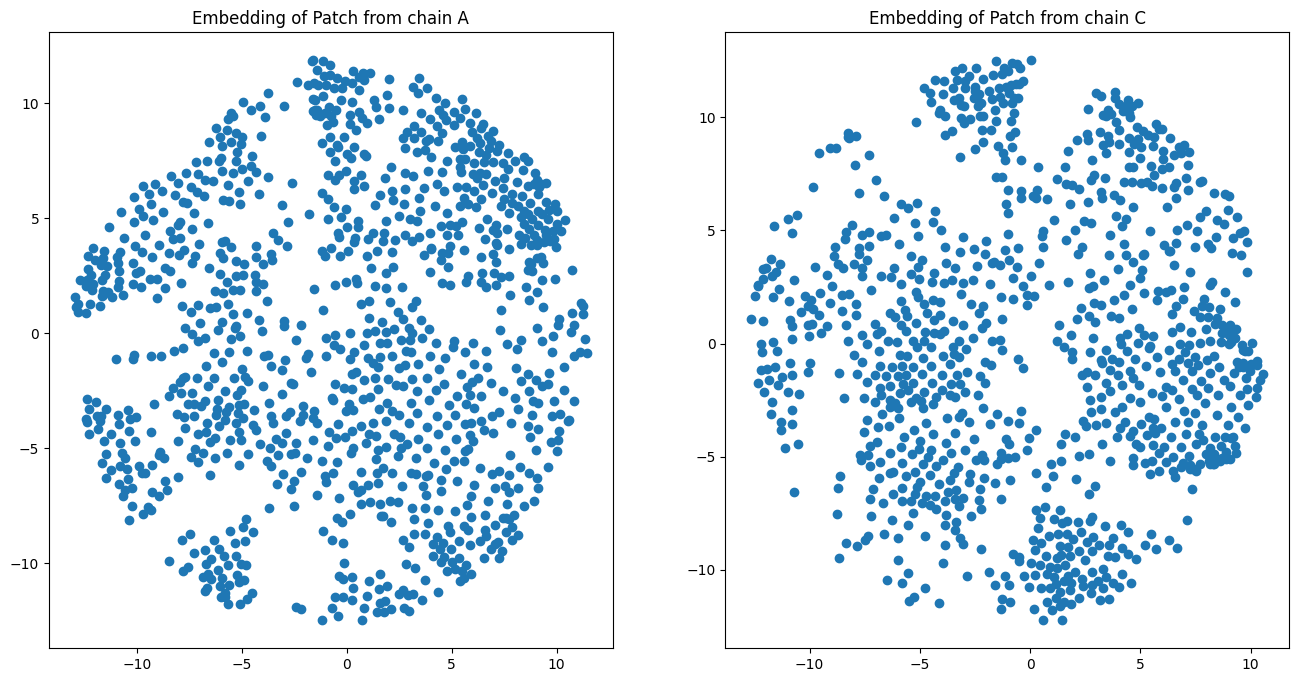

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(embedding_A[:,0], embedding_A[:,1])
plt.title("Embedding of Patch from chain A")

plt.subplot(1,2,2)

plt.scatter(embedding_C[:,0], embedding_C[:,1])
plt.title("Embedding of Patch from chain C")

### Visualize the patch within the points of first_sel

In [11]:
colors_A_test = np.zeros_like(coords_A[patch_A["first_sel"]])
colors_A_test[:] = blue
to_make_red = patch_A["indeces"]
for ind, member in enumerate(patch_A["first_sel"]):
    if member in to_make_red:
        colors_A_test[ind]=red

visualize_pointcloud(coords_A[patch_A["first_sel"]], colors = colors_A_test)


In [12]:
colors_A_test = np.zeros_like(coords_A[patch_A["second_sel"]])
colors_A_test[:] = blue
to_make_red = patch_A["indeces"]
for ind, member in enumerate(patch_A["second_sel"]):
    if member in to_make_red:
        colors_A_test[ind]=red

visualize_pointcloud(coords_A[patch_A["second_sel"]], colors = colors_A_test)


### Visualize the patch within the points of second_sel

In [13]:
colors_C_test = np.zeros_like(coords_C[patch_C["first_sel"]])
colors_C_test[:] = blue
to_make_red = patch_C["indeces"]
for ind, member in enumerate(patch_C["first_sel"]):
    if member in to_make_red:
        colors_C_test[ind]=red

visualize_pointcloud(coords_C[patch_C["first_sel"]], colors = colors_C_test)


In [14]:
colors_C_test = np.zeros_like(coords_C[patch_C["second_sel"]])
colors_C_test[:] = blue
to_make_red = patch_C["indeces"]
for ind, member in enumerate(patch_C["second_sel"]):
    if member in to_make_red:
        colors_C_test[ind]=red

visualize_pointcloud(coords_C[patch_C["second_sel"]], colors = colors_C_test)


In [15]:
features_patch_A = patch_A["features"]
features_patch_C = patch_C["features"]

Text(0.5, 1.0, 'Embedding of Patch from chain C')

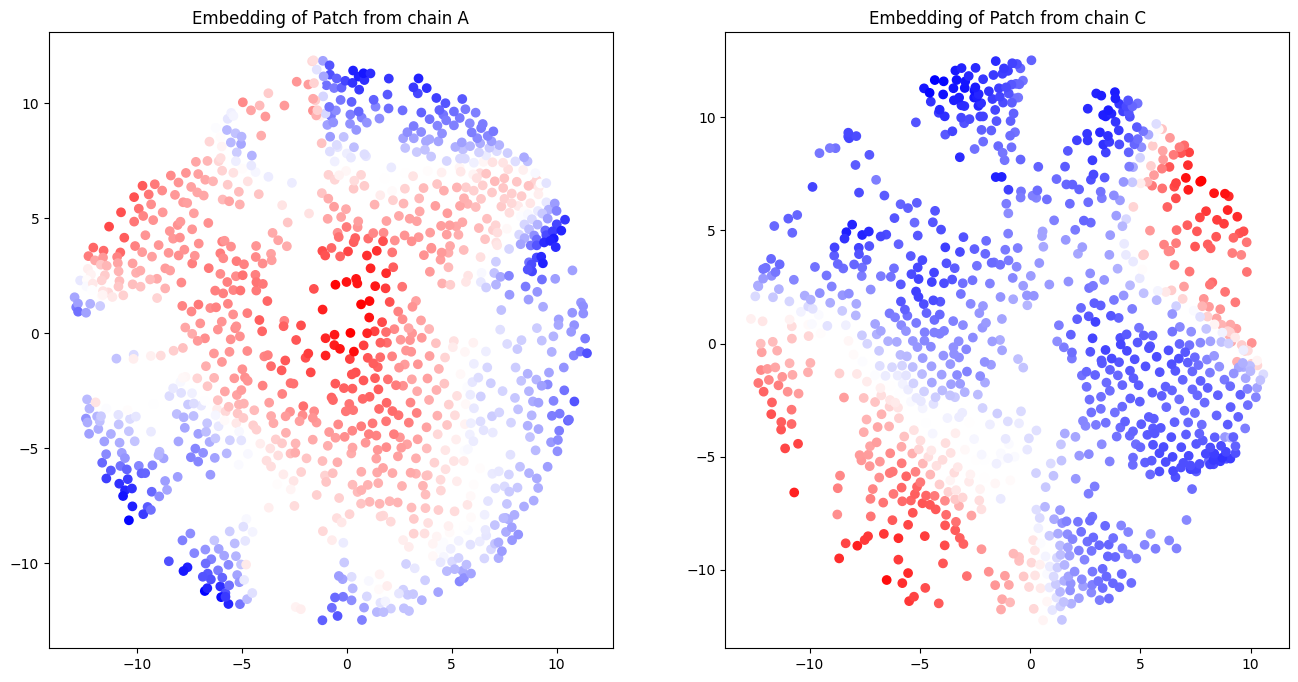

In [16]:
feature = 9

fig, ax = plt.subplots(2, 2, figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(embedding_A[:,0], embedding_A[:,1], c = features_patch_A[:,feature], cmap = "bwr")
plt.title("Embedding of Patch from chain A")

plt.subplot(1,2,2)
plt.scatter(embedding_C[:,0], embedding_C[:,1], c = features_patch_C[:,feature], cmap = "bwr")
plt.title("Embedding of Patch from chain C")


In [17]:
polar_coords_A = convert_to_polar(embedding_A)
polar_coords_C = convert_to_polar(embedding_C)

Text(0.5, 1.0, 'Embedding of Patch from chain C in polar coordinates')

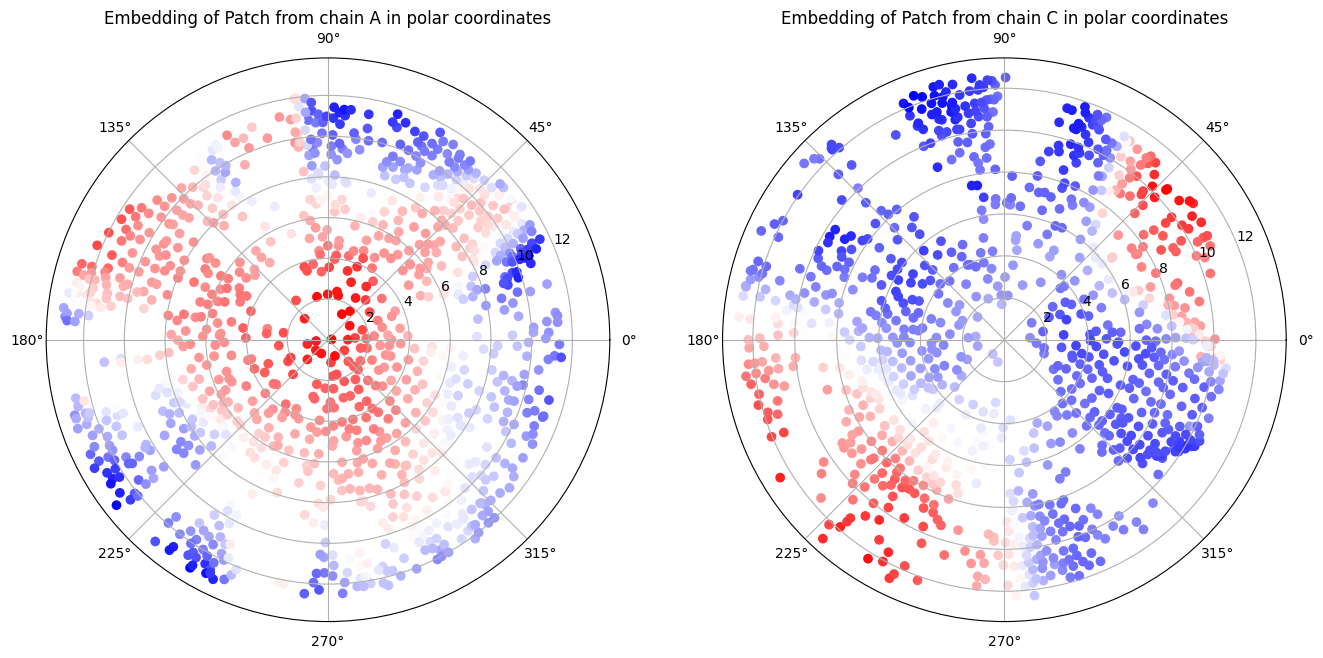

In [18]:
fig = plt.figure(figsize=(16,8))
A = fig.add_subplot(121, projection='polar')
plot1 = A.scatter(polar_coords_A[:,1], polar_coords_A[:,0], c = features_patch_A[:,feature], cmap = "bwr")
plt.title("Embedding of Patch from chain A in polar coordinates")

C= fig.add_subplot(122, projection='polar')
plot2 = C.scatter(polar_coords_C[:,1], polar_coords_C[:,0], c = features_patch_C[:,feature], cmap = "bwr")
plt.title("Embedding of Patch from chain C in polar coordinates")

### Translate the Embedding into radial and angular bins to create array of fixed dimension

In [31]:
# Set the number of radial and angular bins and how many of its nearest neighbors should be taken into 
# account for the calculation of each bins feature vector

n_angular_bins = 72
n_radial_bins = 10
n_neigbors = 3

In [32]:
# Create a feature vector (length 16) for each of the bins and save them in a np.array of shape (angular bins x radial bins x features)

tensor_A = create_ang_rad_bins(n_angular_bins, n_radial_bins, features_patch_A, polar_coords_A, n_neigbors)
tensor_C = create_ang_rad_bins(n_angular_bins, n_radial_bins, features_patch_C, polar_coords_C, n_neigbors)

C:\Users\david\AppData\Local\Temp\ipykernel_24208\3825106622.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax1.pcolormesh(angular_A, radial_A, col_A, cmap = "bwr")
C:\Users\david\AppData\Local\Temp\ipykernel_24208\3825106622.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax2.pcolormesh(angular_C, radial_C, col_C, cmap = "bwr")


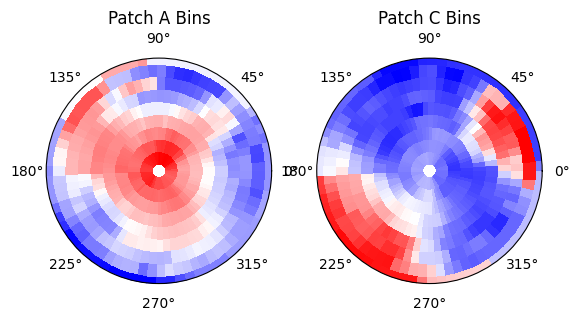

In [35]:
# Create meshgrid for plotting the two patches in bins
max_rho_A = np.max(polar_coords_A[:,0]) # Determine the highest radial coordinate of any point in the patch
angular_A, radial_A = np.mgrid[-np.pi:np.pi:complex(n_angular_bins), 0:max_rho_A:complex(n_radial_bins)]

max_rho_C = np.max(polar_coords_C[:,0]) # Determine the highest radial coordinate of any point in the patch
angular_C, radial_C = np.mgrid[-np.pi:np.pi:complex(n_angular_bins), 0:max_rho_C:complex(n_radial_bins)]

# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw=dict(projection='polar'))

# Patch_A
col_A = tensor_A[:,:, feature] # Select the values of the feature chosen to display
ax1.pcolormesh(angular_A, radial_A, col_A, cmap = "bwr")
ax1.set_title('Patch A Bins')
ax1.set_ylim([0, max_rho_A])
ax1.set_yticklabels([])

# Patch_C
col_C = tensor_C[:,:, feature] # Select the values of the feature chosen to display
ax2.pcolormesh(angular_C, radial_C, col_C, cmap = "bwr")
ax2.set_title('Patch C Bins')
ax2.set_ylim([0, max_rho_C])
ax2.set_yticklabels([])

plt.show()